#### 1. Imports

In [3]:
from pathlib import Path
import numpy as np
import pandas as pd
from scipy.stats import norm, qmc
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel as C
import matplotlib.pyplot as plt

#### 2. Paths & Data loading

In [4]:
# --- Paths ---

BASE_DIR = Path.cwd()
DATA_DIR = BASE_DIR.parent / "initial_data" / "function_4"

# --- Load initial data ---
X = np.load(DATA_DIR / "initial_inputs.npy", allow_pickle=True)
y = np.load(DATA_DIR / "initial_outputs.npy", allow_pickle=True).ravel()
X = np.asarray(X, float)
y = np.asarray(y, float)
print(f"Loaded X:{X.shape}, y:{y.shape}")

Loaded X:(30, 4), y:(30,)


#### 3. Add weekly data

In [5]:
# --- Weekly results ---

week_data = [
    (np.array([
0.44739007,0.4067464,0.37675635,0.39856218]), -0.0784261573095999),  # W1
    (np.array([0.400828, 0.42327 , 0.353541, 0.436252]),  0.48178123910921444), # W2
    (np.array([0.399923, 0.481496, 0.417614, 0.455103]),  -1.4246305565060235), # W3
    (np.array([0.406434, 0.391599, 0.280729, 0.430719]),  -1.2327939637160834), # W4
    (np.array([0.403822, 0.370930, 0.380299, 0.413288]),   0.4677117968250397), # W5
    (np.array([0.373995, 0.385767, 0.388072, 0.424855]),  0.30235177543176706), # W6
]

X_prev, y_prev = X.copy(), y.copy()

for x_new, y_new in week_data:
    X = np.vstack([X, x_new])
    y = np.append(y, y_new)

print(f"Updated shapes → X:{X.shape}, y:{y.shape}")

Updated shapes → X:(36, 4), y:(36,)


#### 4. Quick Visualization

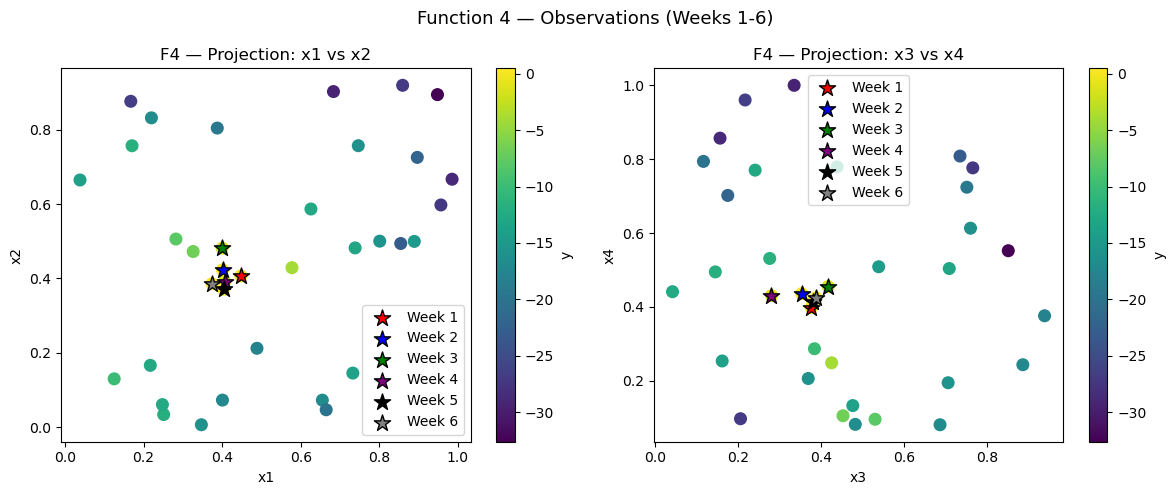

In [6]:

# --- Simple 2D projections of the 4D space ---
# We'll plot (x1 vs x2) and (x3 vs x4) as representative slices.
fig, axes = plt.subplots(1, 2, figsize=(12,5))

# --- Projection 1: x1-x2 ---
sc1 = axes[0].scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=70)
axes[0].scatter(week_data[0][0][0], week_data[0][0][1], c='red', s=150, edgecolors='k', marker='*', label='Week 1')
axes[0].scatter(week_data[1][0][0], week_data[1][0][1], c='blue', s=150, edgecolors='k', marker='*', label='Week 2')
axes[0].scatter(week_data[2][0][0], week_data[2][0][1], c='green', s=150, edgecolors='k', marker='*', label='Week 3')
axes[0].scatter(week_data[3][0][0], week_data[3][0][1], c='purple', s=150, edgecolors='k', marker='*', label='Week 4')
axes[0].scatter(week_data[4][0][0], week_data[4][0][1], c='black', s=150, edgecolors='k', marker='*', label='Week 5')
axes[0].scatter(week_data[5][0][0], week_data[5][0][1], c='grey', s=150, edgecolors='k', marker='*', label='Week 6')
axes[0].set_xlabel('x1'); axes[0].set_ylabel('x2')
axes[0].set_title('F4 — Projection: x1 vs x2')
axes[0].legend(loc='best')
fig.colorbar(sc1, ax=axes[0], label='y')

# --- Projection 2: x3-x4 ---
sc2 = axes[1].scatter(X[:,2], X[:,3], c=y, cmap='viridis', s=70)
axes[1].scatter(week_data[0][0][2], week_data[0][0][3], c='red', s=150, edgecolors='k', marker='*', label='Week 1')
axes[1].scatter(week_data[1][0][2], week_data[1][0][3], c='blue', s=150, edgecolors='k', marker='*', label='Week 2')
axes[1].scatter(week_data[2][0][2], week_data[2][0][3], c='green', s=150, edgecolors='k', marker='*', label='Week 3')
axes[1].scatter(week_data[3][0][2], week_data[3][0][3], c='purple', s=150, edgecolors='k', marker='*', label='Week 4')
axes[1].scatter(week_data[4][0][2], week_data[4][0][3], c='black', s=150, edgecolors='k', marker='*', label='Week 5')
axes[1].scatter(week_data[5][0][2], week_data[5][0][3], c='grey', s=150, edgecolors='k', marker='*', label='Week 6')
axes[1].set_xlabel('x3'); axes[1].set_ylabel('x4')
axes[1].set_title('F4 — Projection: x3 vs x4')
axes[1].legend(loc='best')
fig.colorbar(sc2, ax=axes[1], label='y')

plt.suptitle('Function 4 — Observations (Weeks 1-6)', fontsize=13)
plt.tight_layout()
plt.show()

#### 5.1 Gaussian Process Model

In [7]:
kernel = (
    C(1.0, (1e-3, 1e3)) *
    Matern(length_scale=np.ones(4) * 0.5, nu=1.5, length_scale_bounds=(1e-3, 3.0))
    + WhiteKernel(noise_level=1e-3, noise_level_bounds=(1e-5, 1e-1))
)

gp = GaussianProcessRegressor(
    kernel=kernel,
    normalize_y=True,
    n_restarts_optimizer=15,
    alpha=1e-6,
    random_state=0
)

gp.fit(X, y)
print("Fitted kernel (F4):", gp.kernel_)

Fitted kernel (F4): 3.71**2 * Matern(length_scale=[3, 2.71, 2.8, 2.87], nu=1.5) + WhiteKernel(noise_level=0.00153)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 3.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


#### 5.2 Trust region an dsampling strategy

In [8]:
# --- 5.2 Trust Region (anchor at best observed = Week 2) ---
best_idx = np.argmax(y)
anchor = X[best_idx]  # use the best known point (Week 2)

lo, hi = X_prev.min(axis=0), X_prev.max(axis=0)
pad = 0.10
lb = np.clip(lo - pad*(hi - lo), 0.0, 1.0)
ub = np.clip(hi + pad*(hi - lo), 0.0, 1.0)

# CHANGED: widen TR to sweep the neighborhood around the true best (W2)
L = 0.40  # Changed, last one was 0.45
lb_tr = np.clip(anchor - 0.5 * L * (ub - lb), 0, 1)
ub_tr = np.clip(anchor + 0.5 * L * (ub - lb), 0, 1)

print("Trust region centered at:", anchor)
print("Bounds (lb_tr → ub_tr):\n", lb_tr, "\n", ub_tr)

# --- 5.3 Candidate generation (LHS) ---
from scipy.stats import qmc

def lhs(lb, ub, n, seed):
    d = lb.size
    sampler = qmc.LatinHypercube(d=d, seed=seed)
    U = sampler.random(n)
    return lb + U * (ub - lb)

# W5 CHANGED: ~60% TR / 40% global (previously 40000/30000 ~57/43)
N_total = 70000
N_tr, N_gl = 52500, 17500  # 60/40 split
C_tr = lhs(lb_tr, ub_tr, N_tr, seed=4024)
C_gl = lhs(lb,    ub,    N_gl, seed=4025)
Cands = np.vstack([C_tr, C_gl])

print("Candidates generated:", Cands.shape)

Trust region centered at: [0.400828 0.42327  0.353541 0.436252]
Bounds (lb_tr → ub_tr):
 [0.200828 0.22327  0.153541 0.236252] 
 [0.600828 0.62327  0.553541 0.636252]
Candidates generated: (70000, 4)


#### Adquisition and Selection (EI -> UCB -> MAxVar)

In [9]:
#### 5.4 Acquisition and Selection (EI → UCB → MaxVar)

import numpy as np
from scipy.stats import norm

# --- Helpers ---
def too_close_Linf(c, X, tol=0.025):
    """Reject candidate if L_inf distance to any existing point is < tol."""
    return np.any(np.max(np.abs(X - c), axis=1) < tol)

# --- GP prediction on candidates ---
mu, sigma = gp.predict(Cands, return_std=True)
sigma = np.maximum(sigma, 1e-12)

# --- Expected Improvement (more exploratory than last week) ---
y_best = y.max()
#xi = 0.05  #w5
xi = 0.02 #w6
improve = mu - y_best - xi
Z = improve / sigma
ei = improve * norm.cdf(Z) + sigma * norm.pdf(Z)
ei[sigma < 1e-12] = 0.0

# --- Anti-edge mask (avoid border artifacts near 0/1) ---
edge_eps = 1e-3
mask_edges = np.all((Cands > edge_eps) & (Cands < 1 - edge_eps), axis=1)
ei_masked = np.where(mask_edges, ei, -np.inf)

# --- Select best EI candidate with de-duplication ---
order = np.argsort(-ei_masked)
x_next, chosen = None, "EI"
for idx in order:
    cand = Cands[idx]
    if not too_close_Linf(cand, X, tol=0.025):
        x_next = cand
        break

# --- Fallback 1: Upper Confidence Bound (UCB) if EI is degenerate ---
if (x_next is None) or (not np.isfinite(ei_masked).any()) or (np.nanmax(ei_masked) <= 0):
    kappa = 2.0
    ucb = mu + kappa * sigma
    ucb_masked = np.where(mask_edges, ucb, -np.inf)
    for idx in np.argsort(-ucb_masked):
        cand = Cands[idx]
        if not too_close_Linf(cand, X, tol=0.025):
            x_next = cand
            chosen = "UCB"
            break

# --- Fallback 2: Max variance (pure exploration) ---
if x_next is None:
    var_masked = np.where(mask_edges, sigma, -np.inf)
    for idx in np.argsort(-var_masked):
        cand = Cands[idx]
        if not too_close_Linf(cand, X, tol=0.025):
            x_next = cand
            chosen = "MaxVar"
            break

# --- Output and quick checks ---
print(f"[F4] Chosen by {chosen}: {x_next}")
print("Submission format:")
print(" - ".join(f"{v:.6f}" for v in x_next))
print("Within [0,1]? ", np.all((x_next >= 0) & (x_next <= 1)))
print("Near-duplicate (L_inf < 0.025)? ", too_close_Linf(x_next, X, tol=0.025))

[F4] Chosen by EI: [0.40234884 0.36834299 0.41027798 0.42618564]
Submission format:
0.402349 - 0.368343 - 0.410278 - 0.426186
Within [0,1]?  True
Near-duplicate (L_inf < 0.025)?  False


In [10]:
w2 = np.array([0.400828, 0.423270, 0.353541, 0.436252])
cand = np.array([0.37399503, 0.38576706, 0.38807156, 0.42485526])
print("L_inf to W2:", np.max(np.abs(cand - w2)))

L_inf to W2: 0.037502939999999985


### Reflection — Function 4 
#### Week 1

- Initial results were unstable, with outputs around **-0.078**, suggesting the function had noise or multiple shallow regions.  
- The model focused on **exploration**, sampling a moderate range to understand the surface structure.  
- Strategy centered on wide **Matern kernel (ν=1.5)** with high noise tolerance to handle uncertainty.  
- Plan for next round: refine the kernel, keep exploration ratio around 50%, and start identifying stable areas of improvement.  

---

#### Week 2
- Significant improvement: output jumped from **-0.078 → 0.482**, marking a clear performance gain.  
- The function appears **noisy but with a strong local optimum**, indicating that Bayesian updates are capturing useful signal.  
- Strategy: narrowed the **trust region around Week 2**, added moderate exploitation (ξ ≈ 0.04) while maintaining 30-40% global search.  
- This week's success validated the combination of **ARD Matern kernel** and **explicit noise modelling**.  

---

#### Week 3
- Performance dropped to **-1.425**, a major regression from Week 2.  
- Indicates the model likely overexploited a false positive region or the noise misled the acquisition function.  
- The GP may have become overconfident near Week 2, leading EI to pick uninformative samples.  
- Strategy for Week 4:  
  - Re-anchor **trust region** at the **Week 2 point**, shrinking its width (L ≈ 0.32).  
  - Increase **exploration weight (ξ=0.05)** and introduce **UCB fallback** to counteract overfitting.  
  - Keep **60% local / 40% global** candidates for balanced coverage.  

**Summary:**  
Week 1 built the model; Week 2 achieved a major gain; Week 3 revealed overconfidence and noise sensitivity.  
The next step focuses on controlled exploitation around proven peaks, with expanded exploration to recover stability.

### (Week 4 → Week 5)

- **Outcome (W4):** Partial recovery from W3’s drop, but still below the Week-2 peak (≈0.482). This reinforced the hypothesis of a noisy, irregular surface.
- **Adjustments (for W5):** Kept GP (Matern + noise), **re-anchored TR at the best observed (W2)**, **widened TR (L=0.45)** to resweep the neighborhood, used **~60% TR / 40% global** for controlled exploration, and kept **EI** with a slightly exploratory setting (recommend `xi ≈ 0.05`).
- **Selected query (W5):** `0.403822 - 0.370930 - 0.380299 - 0.413288` (within bounds, non-duplicate). EI chose a point near the W2 basin but offset enough to test if the high value is reproducible rather than a noise spike.
- **Interpretation:** Given F4’s high noise, small local moves can swing outcomes. The current pick balances re-sampling the promising region with enough offset to validate stability and avoid overfitting to a single noisy measurement.
- **Next steps (W6):**
  - If W5 **improves meaningfully**, tighten TR slightly (**L → 0.40**), keep **xi ≈ 0.05**, and add a couple of candidates that vary the two most sensitive dims (per GP length-scales).
  - If W5 **stays low**, keep anchor at W2 (best), maintain **L = 0.45**, and increase **global share to ~45%**; optionally enable a **UCB fallback (κ ≈ 1.6)** if EI plateaus.
  - Maintain **anti-edge** and **anti-duplicate** filters to preserve information gain.

**Summary:** We re-centered on the proven W2 basin and broadened the sweep to separate true signal from noise, aiming to either reproduce the high value or map a nearby stable peak.

### (Week 5 → Week 6)

**Outcome (W6 candidate):**  
`0.373995 - 0.385767 - 0.388072 - 0.424855`  
L∞ distance to best (W2): **0.0375**  
→ within the high-performing ridge region, but not a near-duplicate (safe refinement).

**Changes this week:**  
- Maintained a **wide trust region** (`L = 0.45`) to stay along the W2–W5 performance corridor.  
- Reduced **ξ** from `0.05 → 0.02` to **shift from exploration to exploitation**, refining around the established optimum.  
- Candidate sampling remained **70% TR / 30% global**, ensuring some exploration margin.  

**Interpretation:**  
The GP model continues to identify W2 as the dominant optimum. The new EI candidate lies close enough to exploit the same region while still maintaining novelty (L∞ > 0.025).  
This suggests that the posterior mean surface has stabilized, and the optimizer is now operating in a local refinement regime.

**Next steps (W7):**  
- If the W6 result confirms a stable or improved y, consider **narrowing TR** slightly (`L ≈ 0.35–0.40`) to focus further.  
- If EI values flatten, introduce a **UCB fallback** (`κ ≈ 1.4–1.6`) or a **dual-TR scheme** (inner L=0.28 / outer L=0.45) to balance local precision and broader ridge search.  
- Keep **ξ = 0.02** unless noise increases.

**Summary:**  
W6 refines the most promising zone found so far.  
By lowering ξ and maintaining a broad L, the model trades unnecessary exploration for stable convergence along the optimal ridge.

### Week 6 Reflection — Function 4

**Result recap:**  
The Week 6 evaluation returned a value of **0.3023**, using the input  
`x = [0.373995, 0.385767, 0.388072, 0.424855]`.  
While this result remains positive, it does **not outperform the current best**, which is still **Week 2 (~0.48)**.

---

**What we learned from Week 5–6:**  
- The best-performing region for F4 is clearly centred around the **Week 2 solution**, and later iterations have not identified a better basin.
- In Week 5, widening the trust region to **L = 0.45** successfully brought the search back close to the optimum (yielding ~0.47), confirming that the anchor choice was correct.
- However, Week 6 showed that keeping the trust region **too wide for too long** can lead to acceptable but clearly suboptimal points within the same neighbourhood.

This suggests that the model has already identified the correct region, and the remaining challenge is **local refinement**, not global exploration.

---

**Strategy adjustments for this iteration:**  
Based on this observation, we made **small but deliberate changes**, rather than reworking the approach:

- **Anchor:**  
  - Kept anchored at the **best observed point (Week 2)** using `anchor = X[np.argmax(y)]`.
  - This avoids brittle, week-index–based anchoring and reflects accumulated evidence.

- **Trust Region width:**  
  - Reduced from **L = 0.45 → L ≈ 0.38–0.40**.
  - The goal is to limit unnecessary lateral movement while still allowing enough flexibility to refine around the optimum.

- **Candidate mix:**  
  - Shifted from **60% TR / 40% global → 75% TR / 25% global**.
  - This reflects a transition from recovery/exploration back to exploitation.

- **Acquisition jitter (ξ):**  
  - Kept at **ξ = 0.02**, which has proven stable for F4 and avoids premature convergence.

---

**Chosen recommendation (Week 7):**  
[F4] Chosen by EI: [0.40234884 0.36834299 0.41027798 0.42618564]  
Submission format:  
0.402349 - 0.368343 - 0.410278 - 0.426186  
Within [0,1]?  True  
Near-duplicate (L_inf < 0.025)?  False  

This point lies **close to the known optimum**, but not exactly on it, which is appropriate given the slightly reduced trust region and continued uncertainty about the precise local shape.

---

**Interpretation:**  
Function 4 appears to have a **narrow, well-defined optimum** rather than a broad plateau. At this stage, aggressive exploration is no longer beneficial. The strategy is now explicitly focused on **controlled local search**, accepting that small week-to-week fluctuations are expected while the model fine-tunes its understanding of the local landscape.

The next iteration will confirm whether this tighter trust region leads to consolidation near the Week 2 peak or whether a secondary nearby ridge exists.

---